In [1]:
import numpy as np
import os, sys, scipy
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
import scikits.bootstrap as bootstrap  
from scipy.stats.stats import spearmanr, zscore
from scipy.ndimage.filters import gaussian_filter1d
from necessary_analysis_scripts import prettify_plot, calculate_aprime, load_data, load_data_cd
from necessary_analysis_scripts import run_stats_onetail, run_stats_twotail

# Plotting defaults 

In [2]:
#plot within jupyter notebooks
%matplotlib inline 

#tab completion for files
%config IPCompleter.greedy=True 

#supress scientific notation
np.set_printoptions(suppress=True) 

#font defaults
plt.rcParams.update({'font.size': 14})
rc('text', usetex=False)
plt.rcParams['pdf.fonttype'] = 42
if os.path.isfile("/Library/Fonts/HelveticaNeue-Light.ttf"): 
    prop = fm.FontProperties(fname="/Library/Fonts/HelveticaNeue-Light.ttf",size=24)
else:
    prop = fm.FontProperties(size=24)

#color defaults
col_corr = [0/255.,98/255.,100/255.]
col_incorr = [218/255.,66/255.,36/255.]

# Load data

In [3]:
#project directory 
project_name = 'expt2b' #either expt2a or expt2b

#load data 
subj_dat = load_data(project_name)

#basic project information
nsubj = len(subj_dat) #number of subjects
print("# of subjects:", nsubj)

nb = 4                #number of blocks
nt = 800              #number of trials
nprobes = 200         #maximum possible number of memory probes 
ninfreq = 320         #number of infrequent trials (.1*nb*nt[])
ncolors = 9           #number of possible colors 
setsize = 6           #number of items per display

# of subjects: 23


# Sustained attention performance

First, let's examine the performance in the sustained attention task

In this Sustained Attention to Response Task (or SART), participants respond to the shape of the items. However, 90% of the items are circles and 10% of the items are squares. These imbalances make participants much more likely to make errors to the infrequent trials

Sensitivity (A'):	 0.82 	95% CIs [0.8  0.85]
Accuracy:
Infrequent trials:	 0.55 	95% CIs [0.47 0.62]
Frequent trials:	 0.94 	95% CIs [0.91 0.97]
Parametric: ttest: t  10.84 p 1.36e-10
Nonparametric p < 0.001


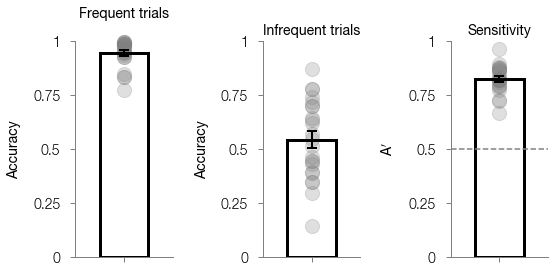

In [4]:
#calculate the accuracy in the sustained attention task
freq_acc, infreq_acc, aprime = np.zeros(nsubj), np.zeros(nsubj), np.zeros(nsubj)
for isubj in range(nsubj):
    acc = np.ravel(subj_dat[isubj].acc[:(nb*nt)]) #accuracy to all trials
    freq_trials = np.ravel(subj_dat[isubj].freq_trials[:(nb*nt)]) #locate frequent triaks
    freq_acc[isubj] = np.mean(acc[freq_trials==1]==1) #calculate average frequent trial accuracy
    infreq_acc[isubj] = np.mean(acc[freq_trials==0]==1) #calculate average infrequent trial accuracy
    aprime[isubj] = calculate_aprime(freq_acc[isubj],infreq_acc[isubj]) #sensitivity

#compute the 95% confidence intervals (CIs)
freq_acc_CIs = bootstrap.ci(data=(freq_acc), statfunction=scipy.mean,n_samples=10000)
infreq_acc_CIs = bootstrap.ci(data=(infreq_acc), statfunction=scipy.mean,n_samples=10000)
aprime_CIs = bootstrap.ci(data=(aprime), statfunction=scipy.mean,n_samples=10000)

#print the results (mean + CIs)
print("Sensitivity (A'):\t", np.round(np.mean(aprime),decimals=2), "\t95% CIs", np.round(aprime_CIs,decimals=2))
print("Accuracy:")
print("Infrequent trials:\t", np.round(np.mean(infreq_acc),decimals=2), "\t95% CIs", np.round(infreq_acc_CIs,decimals=2))
print("Frequent trials:\t", np.round(np.mean(freq_acc),decimals=2), "\t95% CIs", np.round(freq_acc_CIs,decimals=2))

#run statistics on accurac
run_stats_onetail(freq_acc,infreq_acc)

def scatter_plot_data(ax,data,x=0):
    n = np.size(data)
    ax.scatter(np.ones(n)+x,data,s=200,facecolor='gray',alpha=.25,clip_on=False)#data points
    ax.bar(1,np.mean(data),.25,color='None',edgecolor='k',linewidth=3)
    #ax.plot((.9+x,1.1+x),np.tile(np.mean(data),2),'k',linewidth=3)#mean
    ax.errorbar(1+x,np.mean(data),yerr=np.std(data)/np.sqrt(n),color='k',linewidth=2,capsize=5,capthick=2)#error bar
    
#Plot sustained attention data
fig, ax = plt.subplots(1,3,figsize=(8,4))

#Left plot: frequent trial error rate
scatter_plot_data(ax[0],freq_acc) 
prettify_plot(ax[0],ylim=[0,1],yt=([0,.25,.5,.75,1]),ytl=([0,.25,.5,.75,1]),yl="Accuracy",ylrot=90,
              xlim=(.75,1.25), xt=([1]),xtl=([""]),t='Frequent trials')

#Middle plot: infrequent trial error rate
scatter_plot_data(ax[1],infreq_acc)
prettify_plot(ax[1],ylim=[0,1],yt=([0,.25,.5,.75,1]),ytl=([0,.25,.5,.75,1]),yl="Accuracy",ylrot=90,
              xlim=(.75,1.25),xt=([1]),xtl=([""]),t='Infrequent trials')

#Right plot: sensitivity 
scatter_plot_data(ax[2],aprime)
ax[2].plot([.75,1.25],[.5,.5],'--',color='gray')
prettify_plot(ax[2],ylrot=90,xlim=(.75,1.25),ylim=[0,1],yt=([0,.25,.5,.75,1]),ytl=([0,.25,.5,.75,1]),yl="A$\'$",
                 xt=([1]),xtl=([""]),t='Sensitivity')

plt.show()

# Sustained attention performance decrements

Another key signature of sustained attention is that performance declines over blocks. We examine the average accuracy to infrequent trials over blocks, and whether a linear fit of these values reliably slopes negative. 

Infreq acc per block: [66. 59. 53. 50.]
Slope:  -5.22 [-7.38 -3.3 ]
Parametric: ttest: t  -4.89 p 3.43e-05
Nonparametric p: = 1.000


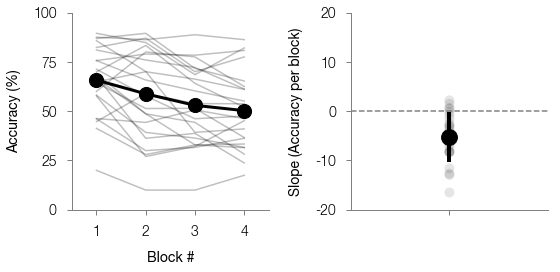

In [5]:
#preallocate
acc_m = np.zeros((nsubj,nb))
pfit_acc = np.zeros((nsubj,2))

#slope
for isubj in range(nsubj):
    for iblock in range(nb):
        itrials = iblock*nt+np.arange(nt)

        idx = (subj_dat[isubj].freq_trials[itrials]==0)
        acc_m[isubj,iblock] = np.nanmean(subj_dat[isubj].acc[itrials[idx]])*100

    pfit_acc[isubj] = np.polyfit(1+np.arange(4),acc_m[isubj],1)

#print summary statistics
pfit_acc_CI = bootstrap.ci(data=pfit_acc[:,0], statfunction=scipy.mean)
print("Infreq acc per block:", np.round(np.mean(acc_m,axis=0),decimals=0))
print("Slope: ", np.round(np.mean(pfit_acc[:,0]),decimals=2),np.round(pfit_acc_CI,decimals=2))
run_stats_onetail(pfit_acc[:,0],0)

#figure
fig, ax = plt.subplots(1,2,figsize=(8,4))

#mean RT per block
ax[0].plot(1+np.arange(4),np.transpose(acc_m),color='k',alpha=.25)
ax[0].scatter(1+np.arange(4),np.mean(acc_m,axis=0),200,color='k')
ax[0].plot(1+np.arange(4),np.mean(acc_m,axis=0),color='k',linewidth=3)
prettify_plot(ax[0],ylrot=90,xlim=(.5,4.5),ylim=[0,100],yt=([0,25,50,75,100]),ytl=([0,25,50,75,100]),
              yl="Accuracy (%)",xt=([1,2,3,4]),xtl=([1,2,3,4]),xl='Block #')

#slope of linear fit
ax[1].scatter(np.zeros(nsubj),pfit_acc[:,0],100,color='k',alpha=.1,edgecolor='None')
ax[1].scatter(0,np.mean(pfit_acc[:,0]),250,color='k')
ax[1].errorbar(0,np.mean(pfit_acc[:,0]),yerr=np.std(pfit_acc[:,0]),color='k',linewidth=4)
ax[1].plot([-.5,.5],[0,0],'--',color='gray')
prettify_plot(ax[1],ylrot=90,xlim=(-.5,.5),ylim=[-20,20],yt=([-20,-10,0,10,20]),ytl=([-20,-10,0,10,20]),
              yl="Slope (Accuracy per block)",xt=([0]),xtl=([" "]))

plt.show()


/Users/megan/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:942: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


RT incorr: 333 [312 361]
RT corr: 390 [363 415]
Parametric: ttest: t  9.51 p 1.49e-09
Nonparametric p < 0.001


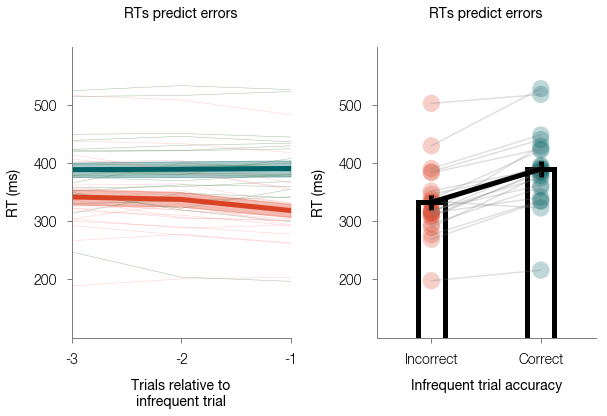

In [6]:
shifts = [-3,-2,-1] #trials pre-probe trial
nshifts = np.size(shifts)

rts_corr_m = np.zeros((nsubj,nshifts))
rts_incorr_m = np.zeros((nsubj,nshifts))
probe_inacc = np.zeros(nsubj)
wm_n_all = np.zeros((nsubj,nprobes))
wm_n_corr = np.empty(nsubj)
wm_n_incorr = np.empty(nsubj)
wm_n_diff = np.empty(nsubj)
nbins = 11
infreq_propacc_bin = np.empty((nsubj,nbins))
wm_n_bin = np.empty((nsubj,nbins))

for isubj in range(nsubj):
    
    #index relevant trial locations
    infreq_trials = np.where(subj_dat[isubj].freq_trials[:(nb*nt)]==0)[0]
    infreq_acc = subj_dat[isubj].acc[infreq_trials]==1
    infreq_corr = np.where(subj_dat[isubj].acc[infreq_trials]==1)[0]
    infreq_incorr = np.where(subj_dat[isubj].acc[infreq_trials]!=1)[0]
    
    #reaction times
    rts = subj_dat[isubj].rts
    rts_shift = np.zeros((np.size(infreq_trials),nshifts)) #preallocate the shifted RTs
    rts_shift[:]= np.nan
    
    #shift rts relative to infrequent trial
    for i,ishift in enumerate(shifts):
         
        infreq_s = infreq_trials + ishift #infrequent trial indices, shifted back one 
        infreq_s = infreq_s[np.logical_and((infreq_s%nt)>=0,(infreq_s%nt)<nt)] #ensure doesn't span blocks
        
        #grab the RTs for the preceding trials
        rts_shift[np.logical_and((infreq_s%nt)>=0,(infreq_s%nt)<nt),i] = rts[infreq_s]
    
        rts_corr_m[isubj,i] = np.nanmean(rts_shift[infreq_corr,i]) #mean RT across trials pre and post correct response
        rts_incorr_m[isubj,i] = np.nanmean(rts_shift[infreq_incorr,i]) #mean RT across trials pre and post incorrect response
    
CIs = bootstrap.ci(data=(rts_incorr_m*1000), statfunction=scipy.mean,n_samples=10000)
print("RT incorr:", int(np.round(np.mean(rts_incorr_m*1000),decimals=0)), (np.round(CIs,decimals=0)).astype(int))
CIs = bootstrap.ci(data=(rts_corr_m*1000), statfunction=scipy.mean,n_samples=10000)
print("RT corr:", int(np.round(np.mean(rts_corr_m*1000),decimals=0)), (np.round(CIs,decimals=0)).astype(int))
run_stats_onetail(np.mean(rts_corr_m,axis=1)*1000,np.mean(rts_incorr_m,axis=1)*1000)

#MAKE FIGURE
fig = plt.figure(figsize=(12,6))

#plot sustained attention performance
ax = plt.subplot(132)
for isubj in range(nsubj):
    ax.plot(shifts,rts_corr_m[isubj]*1000,color=[.3,.5,.3],alpha=.5,linewidth=.5)#correct trials
    ax.plot(shifts,rts_incorr_m[isubj]*1000,color=[1,.6,.6],alpha=.5,linewidth=.5)#incorrect trials
    
#plot averages
ax.fill_between(shifts,np.mean(rts_corr_m*1000,axis=0)-np.std(rts_corr_m*1000,axis=0)/np.sqrt(nsubj),
                np.mean(rts_corr_m,axis=0)*1000+np.std(rts_corr_m*1000,axis=0)/np.sqrt(nsubj),
                alpha=.35,color=col_corr,edgecolor='None')#correct trials
ax.fill_between(shifts,np.mean(rts_incorr_m*1000,axis=0)-np.std(rts_incorr_m*1000,axis=0)/np.sqrt(nsubj),
                np.mean(rts_incorr_m,axis=0)*1000+np.std(rts_incorr_m*1000,axis=0)/np.sqrt(nsubj),
                alpha=.35,color=col_incorr,edgecolor='None')#incorrect trials
ax.plot(shifts,np.mean(rts_corr_m,axis=0)*1000,color=col_corr,linewidth=5)#incorrect trials
ax.plot(shifts,np.mean(rts_incorr_m,axis=0)*1000,color=col_incorr,linewidth=5)#incorrect trials
prettify_plot(ax,ylim=([100,600]),yt=([200,300,400,500]),ytl=([200,300,400,500]),yl='RT (ms)',ylrot=90,
              xlim=(-3,-1),xl='Trials relative to\ninfrequent trial', xt=([-3,-2,-1]),xtl=([-3,-2,-1]),
              t='RTs predict errors')

#plot average pre-trial sustained attention performance
ax = plt.subplot(133)
ax.scatter(np.zeros(nsubj),np.mean(rts_incorr_m,axis=1)*1000,s=300,color=col_incorr,edgecolor='None',alpha=.25)#incorrect trials
ax.scatter(np.ones(nsubj),np.mean(rts_corr_m,axis=1)*1000,s=300,color=col_corr,edgecolor='None',alpha=.25)#correct trials
ax.plot([0,1],[np.mean(rts_incorr_m,axis=1)*1000,np.mean(rts_corr_m,axis=1)*1000],color='gray',alpha=.25)
ax.bar(0,np.mean(rts_incorr_m)*1000,.25,color='None',edgecolor='k',linewidth=5)#correct trials
ax.bar(1,np.mean(rts_corr_m)*1000,.25,color='None',edgecolor='k',linewidth=5)#incorrect trials
ax.errorbar(0,np.mean(rts_incorr_m)*1000,yerr=np.std(rts_incorr_m)*1000/np.sqrt(nsubj),color='k',linewidth=5)
ax.errorbar(1,np.mean(rts_corr_m)*1000,yerr=np.std(rts_corr_m)*1000/np.sqrt(nsubj),color='k',linewidth=5)
ax.plot([0,1],[np.mean(rts_incorr_m)*1000,np.mean(rts_corr_m)*1000],color='k',linewidth=5)#incorrect trials
prettify_plot(ax,ylim=([100,600]),yt=([200,300,400,500]),ytl=([200,300,400,500]),yl='RT (ms)',ylrot=90,
              xlim=(-.5,1.5),xt=([0,1]),xtl=(['Incorrect','Correct']),xl='Infrequent trial accuracy',
              t='RTs predict errors')

plt.show()

# Working memory performance 

Now, let's examine the performance in the working memory task

In this whole report working memory task, participants respond to the color of the items. These memory probes are rare, only occuring 5% of the time. On each trial, participants have to select the color of all 6 items. 

Working memory performance:	 2.17 [1.97 2.36]
Parametric: ttest: t  14.63 p 4.05e-13
Nonparametric p < 0.001


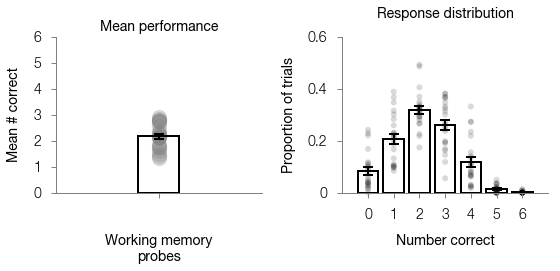

In [7]:
wm_n =np.zeros(nsubj) 
n_correct = np.arange(8)
bin_height_n = np.empty((nsubj,np.size(n_correct)-1))
wm_n_all = np.empty((nsubj,nprobes))
wm_n_all[:] = np.nan

#calculate working memory performance
for isubj in range(nsubj):
    probe_trials = np.ravel(subj_dat[isubj].probe_trials[:(nb*nt)])==1 #working memory probes (boolean)
    nprobes = np.sum(probe_trials)
    wm_n_all[isubj][:nprobes] = subj_dat[isubj].wholereport_respacc_total[:(nb*nt)][probe_trials] #number correct for probes
    wm_n[isubj] = np.nanmean(wm_n_all[isubj]) #whole report trial accuracy
    a,_ = np.histogram(wm_n_all[isubj][:nprobes],n_correct,density=True)
    bin_height_n[isubj],_ = np.histogram(wm_n_all[isubj][:nprobes],n_correct,density=True) #histogram bin height
    

#Confidence intervals
wm_n_CIs = bootstrap.ci(data=wm_n, statfunction=scipy.mean) #confidence intervals
wm_chance = setsize/float(ncolors) #chance performance
print("Working memory performance:\t", np.round(np.mean(wm_n),decimals=2), np.round(wm_n_CIs,decimals=2))
run_stats_onetail(wm_n-wm_chance) #note this is a bit of a shortcut for the actual stats... 

#Plot distribution of whole report performance
fig, ax = plt.subplots(1,2,figsize=(8,4))

#Left plot: distribution 
ax[1].bar(n_correct[:-1],np.mean(bin_height_n,axis=0),color='None',edgecolor='k',linewidth=2)
ax[1].errorbar(n_correct[:-1],np.mean(bin_height_n,axis=0),yerr=np.std(bin_height_n,axis=0)/np.sqrt(float(nsubj)),
    linestyle='None',color='k',linewidth=2,capsize=5,capthick=2)
for ib in n_correct[:-1]:
    ax[1].scatter(np.zeros(nsubj)+ib,bin_height_n[:,ib],color='k',alpha=.15,linewidths=None,edgecolors='none',clip_on=False)
prettify_plot(ax[1],ylim=[0,.6],yt=([0,.2,.4,.6]),ytl=([0,.2,.4,.6]),yl='Proportion of trials',ylrot=90,
                    xlim=(-1,7),xt=([0,1,2,3,4,5,6]),xtl=([0,1,2,3,4,5,6]),xl='Number correct',
                    t='Response distribution')

#Right plot: average performance
ax[0].scatter(np.ones(nsubj),wm_n,s=200,facecolor='gray',alpha=.25,clip_on=False)
ax[0].bar(1,np.mean(wm_n),.1,color='None',edgecolor='k',linewidth=2)
ax[0].errorbar(1,np.mean(wm_n),yerr=np.std(wm_n)/np.sqrt(float(nsubj)),
    linestyle='None',color='k',linewidth=2,capsize=5,capthick=2)
prettify_plot(ax[0],ylim=[0,6],yt=([0,1,2,3,4,5,6]),ytl=([0,1,2,3,4,5,6]),yl='Mean # correct',ylrot=90,
              xlim=(.75,1.25),xt=([1]),xtl=' ',xl=("Working memory\nprobes"),t='Mean performance')
        
plt.show()

# Real-time triggering

Now, let's examine the memory consequences of the real-time triggering procedure. 

In Experiment 2, memory probes were triggered based on the RTs. If participants were responding more quickly, we triggered a "fast memory probe" and predicted that memory performance would be worse. If participants were responding more quickly, we triggered a "slow memory probe" and predicted that memory performance would be better. We assessed memory performance as the number of items that the participants got correct. 

# fast: 55.74 [49.78 59.35]
# slow: 53.26 [49.35 56.52]
Parametric: ttest: t  -0.86 p 3.99e-01
Nonparametric p: = 0.390
# slow: 2.48 [-2.78  8.39]

# infreq, fast: 0
# infreq, slow: 0

RT fast: 235 [208 266]
RT slow: 519 [484 547]
RT diff: 284 [264 306]
Parametric: ttest: t  26.44 p 1.81e-18
Nonparametric p < 0.001
2.095326718765853 2.262970293142743 0.16764357437689006

WM n fast: 2.1 [1.89 2.31]
WM n slow: 2.26 [2.06 2.45]
WM diff: 0.16 [0.09 0.28]
Parametric: ttest: t  3.4 p 1.27e-03
Nonparametric p < 0.001


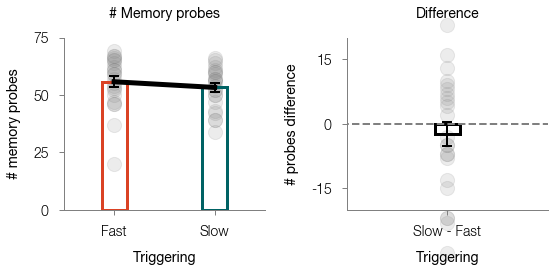

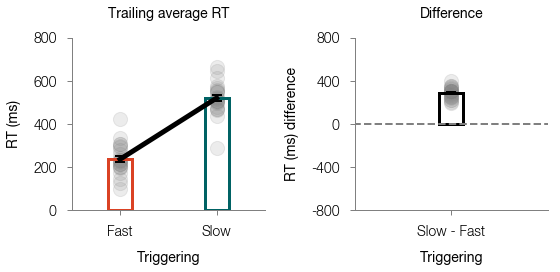

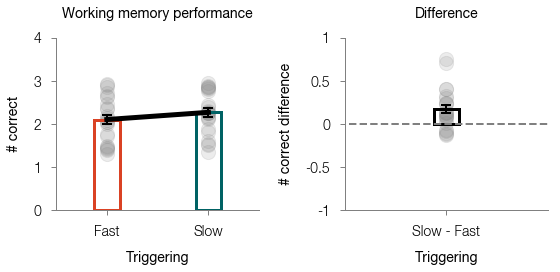

In [8]:
shifts = [-3,-2,-1] #trials pre-probe trial
nshifts = np.size(shifts)

n_fast = np.empty(nsubj,dtype=int)
n_slow = np.empty(nsubj,dtype=int)
n_infreq_fast = np.zeros((nsubj,72))
n_infreq_slow = np.zeros((nsubj,72))
n_infreq_fast[:] = np.nan
n_infreq_slow[:] = np.nan
n_err_fast = np.empty((nsubj),dtype=int)
n_err_slow = np.empty((nsubj),dtype=int)
rt_fast = np.empty(nsubj)
rt_slow = np.empty(nsubj)
rt_var_fast = np.empty(nsubj)
rt_var_slow = np.empty(nsubj)
m_fast = np.empty(nsubj)
m_slow = np.empty(nsubj)

for isubj in range(nsubj):
    if project_name == 'expt2a':
        fast_rt_trigger = np.where(subj_dat[isubj].fast_rt_trigger==1)[0]
        slow_rt_trigger = np.where(subj_dat[isubj].slow_rt_trigger==1)[0]
    elif project_name == 'expt2b':
        fast_rt_trigger = 1+np.intersect1d(np.where(subj_dat[isubj].fast_rt_trigger==1)[0],np.where(subj_dat[isubj].rt_triggered[1:]==1)[0])
        slow_rt_trigger = 1+np.intersect1d(np.where(subj_dat[isubj].slow_rt_trigger==1)[0],np.where(subj_dat[isubj].rt_triggered[1:]==1)[0])      
    
    #number of fast vs. slow trials
    n_fast[isubj] = np.size(fast_rt_trigger)
    n_slow[isubj] = np.size(slow_rt_trigger)

    #number of infrequent trials that served as probes
    for iprobe in range(np.size(fast_rt_trigger)):
        n_infreq_fast[isubj,iprobe] = np.any(subj_dat[isubj].freq_trials[fast_rt_trigger[iprobe]]==0)*1
    for iprobe in range(np.size(slow_rt_trigger)):    
        n_infreq_slow[isubj,iprobe] = np.any(subj_dat[isubj].freq_trials[slow_rt_trigger[iprobe]]==0)*1
    
    #number of infrequent trials in trailing window
    for iprobe in range(np.size(fast_rt_trigger)):
        n_infreq_fast[isubj,iprobe] = np.any(subj_dat[isubj].freq_trials[fast_rt_trigger[iprobe]+shifts]==0)*1
    for iprobe in range(np.size(slow_rt_trigger)):    
        n_infreq_slow[isubj,iprobe] = np.any(subj_dat[isubj].freq_trials[slow_rt_trigger[iprobe]+shifts]==0)*1
    
    #number of errors made to the probe trials 
    n_err_fast[isubj] = np.sum(subj_dat[isubj].acc[fast_rt_trigger]==0)
    n_err_slow[isubj] = np.sum(subj_dat[isubj].acc[slow_rt_trigger]==0)
    
    #average reaction time to the fast vs. slow trials
    rt_fast[isubj] = np.mean(subj_dat[isubj].rts_trailingavg[fast_rt_trigger])*1000
    rt_slow[isubj] =  np.mean(subj_dat[isubj].rts_trailingavg[slow_rt_trigger])*1000
    
    #mean number of items correctly reported for fast vs. slow trials
    m_fast[isubj] = np.mean(subj_dat[isubj].wholereport_respacc_total[fast_rt_trigger])
    m_slow[isubj] =  np.mean(subj_dat[isubj].wholereport_respacc_total[slow_rt_trigger])


#Print 95% confidence intervals for whole report accuracy
CIs = bootstrap.ci(data=(n_fast), statfunction=scipy.mean,n_samples=10000)
print("# fast:", np.round(np.mean(n_fast),decimals=2), np.round(CIs,decimals=2))
CIs = bootstrap.ci(data=(n_slow), statfunction=scipy.mean,n_samples=10000)
print("# slow:", np.round(np.mean(n_slow),decimals=2),np.round(CIs,decimals=2))
run_stats_twotail(n_slow,n_fast)
CIs = bootstrap.ci(data=(n_fast-n_slow), statfunction=scipy.mean,n_samples=10000)
print("# slow:", np.round(np.mean(n_fast-n_slow),decimals=2),np.round(CIs,decimals=2))

if project_name == 'expt2a':
    CIs = bootstrap.ci(data=(np.nansum(n_infreq_fast,axis=1)), statfunction=scipy.mean,n_samples=10000)
    print("\n# infreq, fast:", int(np.round(np.nanmean(np.nansum(n_infreq_fast,axis=1)),decimals=0)), np.round(CIs,decimals=0).astype(int))
    CIs = bootstrap.ci(data=(np.nansum(n_infreq_slow,axis=1)), statfunction=scipy.mean,n_samples=10000)
    print("# infreq, slow:", int(np.round(np.nanmean(np.nansum(n_infreq_slow,axis=1)),decimals=0)),np.round(CIs,decimals=0).astype(int))
    run_stats_onetail(np.nansum(n_infreq_slow,axis=1),np.nansum(n_infreq_fast,axis=1))
else:
    print("\n# infreq, fast:", int(np.round(np.nanmean(np.nansum(n_infreq_fast,axis=1)),decimals=0)))
    print("# infreq, slow:", int(np.round(np.nanmean(np.nansum(n_infreq_slow,axis=1)),decimals=0)))
    
CIs = bootstrap.ci(data=(rt_fast), statfunction=scipy.mean,n_samples=10000)
print("\nRT fast:", int(np.round(np.mean(rt_fast),decimals=0)), np.round(CIs,decimals=0).astype(int))
CIs = bootstrap.ci(data=(rt_slow), statfunction=scipy.mean,n_samples=10000)
print("RT slow:", int(np.round(np.mean(rt_slow),decimals=0)),np.round(CIs,decimals=0).astype(int))
CIs = bootstrap.ci(data=(rt_slow-rt_fast), statfunction=scipy.mean,n_samples=10000)
print("RT diff:", int(np.round(np.mean(rt_slow-rt_fast),decimals=0)),np.round(CIs,decimals=0).astype(int))
run_stats_onetail(rt_slow,rt_fast)
    
print(np.mean(m_fast),np.mean(m_slow),np.mean(m_slow-m_fast))
CIs = bootstrap.ci(data=(m_fast), statfunction=scipy.mean,n_samples=10000)
print("\nWM n fast:", np.round(np.mean(m_fast),decimals=2), np.round(CIs,decimals=2))
CIs = bootstrap.ci(data=(m_slow), statfunction=scipy.mean,n_samples=10000)
print("WM n slow:", np.round(np.mean(m_slow),decimals=2),np.round(CIs,decimals=2))
CIs = bootstrap.ci(data=(m_slow-m_fast), statfunction=scipy.mean,n_samples=10000)
print("WM diff:", np.round(np.round(np.mean(m_slow),decimals=2)-np.round(np.mean(m_fast),decimals=2),decimals=2),np.round(CIs,decimals=2))
run_stats_onetail(m_slow,m_fast)
    
def scatter_plot_data(ax,data,x=0,c='k'):
    n = np.size(data)
    ax.scatter(np.zeros(n)+x,data,s=200,facecolor='gray',alpha=.15,clip_on=False)#data points
    ax.bar(x,np.mean(data),.25,color='None',edgecolor=c,linewidth=3)
    ax.errorbar(x,np.mean(data),yerr=np.std(data)/np.sqrt(n),color='k',linewidth=2,capsize=5,capthick=2)#error bar

#MAKE FIGURE
fig = plt.figure(figsize=(8,4))
    
#plot sustained attention performance
ax = plt.subplot(121)
scatter_plot_data(ax,n_fast,c=col_incorr)
scatter_plot_data(ax,n_slow,x=1,c=col_corr)
ax.plot([0,1],[np.mean(n_fast),np.mean(n_slow)],color='k',linewidth=5)
prettify_plot(ax,ylim=([0,75]),yt=([0,25,50,75]),ytl=([0,25,50,75]),yl='# memory probes',ylrot=90,
              xlim=(-.5,1.5),xt=([0,1]),xtl=(['Fast','Slow']),xl='Triggering', 
              t='# Memory probes')

ax = plt.subplot(122)
scatter_plot_data(ax,n_slow-n_fast)
ax.plot([-2,2],[0,0],'--',color='gray',linewidth=2)
prettify_plot(ax,ylim=([-20,20]),yt=([-30,-15,0,15,30]),ytl=([-30,-15,0,15,30]),yl='# probes difference',ylrot=90,
              xlim=(-1,1),xt=([0]),xtl=(['Slow - Fast']),xl='Triggering', 
              t='Difference')

#MAKE FIGURE
fig = plt.figure(figsize=(8,4))

ax = plt.subplot(121)
scatter_plot_data(ax,rt_fast,c=col_incorr)
scatter_plot_data(ax,rt_slow,x=1,c=col_corr)
ax.plot([0,1],[np.mean(rt_fast),np.mean(rt_slow)],color='k',linewidth=5)
prettify_plot(ax,ylim=([0,800]),yt=([0,200,400,600,800]),ytl=([0,200,400,600,800]),yl='RT (ms)',ylrot=90,
              xlim=(-.5,1.5),xt=([0,1]),xtl=(['Fast','Slow']),xl='Triggering', 
              t='Trailing average RT')

ax = plt.subplot(122)
scatter_plot_data(ax,rt_slow-rt_fast)
ax.plot([-2,2],[0,0],'--',color='gray',linewidth=2)
prettify_plot(ax,ylim=([-800,800]),yt=([-800,-400,0,400,800]),ytl=([-800,-400,0,400,800]),yl='RT (ms) difference',ylrot=90,
              xlim=(-1,1),xt=([0]),xtl=(['Slow - Fast']),xl='Triggering', 
              t='Difference')

#MAKE FIGURE
fig = plt.figure(figsize=(8,4))

ax = plt.subplot(121)
scatter_plot_data(ax,m_fast,c=col_incorr)
scatter_plot_data(ax,m_slow,x=1,c=col_corr)
ax.plot([0,1],[np.mean(m_fast),np.mean(m_slow)],color='k',linewidth=5)
prettify_plot(ax,ylim=([0,4]), yt=([0,1,2,3,4,5,6]),ytl=([0,1,2,3,4,5,6]),yl='# correct',ylrot=90,
              xlim=(-.5,1.5), xt=([0,1]),xtl=(['Fast','Slow']),xl='Triggering',
              t='Working memory performance')


ax = plt.subplot(122)
scatter_plot_data(ax,m_slow-m_fast)
ax.plot([-2,2],[0,0],'--',color='gray',linewidth=2)
prettify_plot(ax,ylim=([-1,1]), yt=([-1,-.5,0,.5,1]),ytl=([-1,-.5,0,.5,1]),yl='# correct difference',ylrot=90,
              xlim=(-1,1), xt=([0]),xtl=(['Slow - Fast']),xl='Triggering',
              t='Difference')

plt.show()
